In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from google.cloud import storage
import numpy as np
from io import BytesIO

## Make sure not to upload this key to github or anywhere online!

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "x-rai-403303-d80059f325d8.json"

# The actual masking of npy file

In [3]:
def window_image(image, window_level, window_width):
    img_min = window_level - window_width // 2
    img_max = window_level + window_width // 2
    windowed_image = np.clip(image, img_min, img_max)
    return windowed_image

## Getting Shape of OG numpy array from npy file header. We need to do this since we are downloading npy files as bytes (1d array)from GCP bucket.

In [4]:
def read_npy_shape_from_header(blob_bytes):
    with BytesIO(blob_bytes) as f:
        magic_str = f.read(6)
        major_version = ord(f.read(1))
        minor_version = ord(f.read(1))
        
        header_length = int.from_bytes(f.read(2), byteorder='little')
        
        header_bytes = f.read(header_length)
        header_str = header_bytes.decode('latin1')
        
        header_dict = eval(header_str)
        
        return header_dict['shape'], len(header_str)


In [5]:
def process_blob(blob, bucket):
    if blob.name.endswith('.npy'):
        print(f"Processing {blob.name}")

        print("waiting on blob download")
        blob_bytes = blob.download_as_bytes()

        print(f"Blob bytes length: {len(blob_bytes)}")

        # Read header to get original_shape
        original_shape, header_length = read_npy_shape_from_header(blob_bytes)
        print(f"original blob shape: {original_shape}")

        header_size = 6 + 2 + header_length
        print(f"Header size is: {header_size}")
        expected_buffer_length = np.prod(original_shape) * np.dtype(np.int16).itemsize

        print(f"Expected buffer length: {expected_buffer_length}")

        npy_array = np.frombuffer(blob_bytes[header_size:header_size+expected_buffer_length], dtype=np.int16).reshape(original_shape)
        print(f"Successfully reshaped array: {npy_array.shape}")
        # Update window level and width
        window_level = -400
        window_width = 1600
        
        # Apply windowing for each slice in the 3D array and make a copy
        new_npy_array = np.array([window_image(slice, window_level, window_width) for slice in npy_array])
        print("edited new image")
        # Generate new blob name to store the copy
        new_blob_name = f"pre_processed/{blob.name}"
        new_blob = bucket.blob(new_blob_name)

        # Convert numpy array to bytes and upload using NumPy's native save function
        buffer = BytesIO()
        np.save(buffer, new_npy_array)
        buffer.seek(0)
        try:
            new_blob.upload_from_file(buffer, content_type='application/octet-stream')
            print(f"Successfully uploaded {new_blob_name}")
        except Exception as e:
            print(f"Failed to upload {new_blob_name}: {e}")


## Multithreading!!

In [6]:
def process_bucket_files(bucket_name, prefix="", max_workers=10):
    # Initialize the GCS client
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)

    # List .npy blobs from the bucket
    blobs = bucket.list_blobs(prefix=prefix)
    # Multithreading!
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for blob in blobs:
            executor.submit(process_blob, blob, bucket)

In [7]:
process_bucket_files("x_rai-dataset", prefix="multimodalpulmonaryembolismdataset/2")

Processing multimodalpulmonaryembolismdataset/2/1855.npyProcessing multimodalpulmonaryembolismdataset/2/1856.npy
waiting on blob download
Processing multimodalpulmonaryembolismdataset/2/1857.npy
waiting on blob download

waiting on blob download
Processing multimodalpulmonaryembolismdataset/2/1858.npy
waiting on blob download
Processing multimodalpulmonaryembolismdataset/2/186.npy
waiting on blob download
Processing multimodalpulmonaryembolismdataset/2/1862.npy
waiting on blob download
Processing multimodalpulmonaryembolismdataset/2/1864.npy
waiting on blob download
Processing multimodalpulmonaryembolismdataset/2/1865.npy
waiting on blob download
Processing multimodalpulmonaryembolismdataset/2/1868.npy
waiting on blob download
Processing multimodalpulmonaryembolismdataset/2/187.npy
waiting on blob download
Blob bytes length: 103284864
original blob shape: (197, 512, 512)
Header size is: 126
Expected buffer length: 103284736
Successfully reshaped array: (197, 512, 512)
edited new image


In [8]:
process_bucket_files("x_rai-dataset", prefix="multimodalpulmonaryembolismdataset/3")

Processing multimodalpulmonaryembolismdataset/3/2241.npyProcessing multimodalpulmonaryembolismdataset/3/2243.npy
waiting on blob download

waiting on blob download
Processing multimodalpulmonaryembolismdataset/3/2246.npy
waiting on blob download
Processing multimodalpulmonaryembolismdataset/3/2247.npy
waiting on blob download
Processing multimodalpulmonaryembolismdataset/3/2248.npy
waiting on blob download
Processing multimodalpulmonaryembolismdataset/3/2249.npy
waiting on blob download
Processing multimodalpulmonaryembolismdataset/3/225.npy
waiting on blob download
Processing multimodalpulmonaryembolismdataset/3/2250.npy
waiting on blob download
Processing multimodalpulmonaryembolismdataset/3/2251.npy
waiting on blob download
Processing multimodalpulmonaryembolismdataset/3/2253.npy
waiting on blob download
Blob bytes length: 199229568
original blob shape: (380, 512, 512)
Header size is: 126
Expected buffer length: 199229440
Successfully reshaped array: (380, 512, 512)
edited new image

In [9]:
process_bucket_files("x_rai-dataset", prefix="multimodalpulmonaryembolismdataset/4")

Processing multimodalpulmonaryembolismdataset/4/2730.npyProcessing multimodalpulmonaryembolismdataset/4/2732.npy
waiting on blob download

waiting on blob download
Processing multimodalpulmonaryembolismdataset/4/2733.npy
waiting on blob download
Processing multimodalpulmonaryembolismdataset/4/2736.npy
waiting on blob download
Processing multimodalpulmonaryembolismdataset/4/2738.npy
waiting on blob download
Processing multimodalpulmonaryembolismdataset/4/2740.npy
waiting on blob download
Processing multimodalpulmonaryembolismdataset/4/2747.npy
waiting on blob download
Processing multimodalpulmonaryembolismdataset/4/2749.npy
waiting on blob download
Processing multimodalpulmonaryembolismdataset/4/275.npy
waiting on blob download
Processing multimodalpulmonaryembolismdataset/4/2753.npy
waiting on blob download
Blob bytes length: 127926400
original blob shape: (244, 512, 512)
Header size is: 126
Expected buffer length: 127926272
Successfully reshaped array: (244, 512, 512)
edited new image

# Displaying Post-Processed Images

In [10]:
def display_middle_slice(npy_array):
    # Determine the middle slice index
    middle_slice_index = npy_array.shape[0] // 2

    # Select the middle slice
    middle_slice = npy_array[middle_slice_index]

    # Display the slice
    plt.imshow(middle_slice, cmap='gray')
    plt.colorbar()
    plt.show()

In [11]:
def process_folder_for_visualization(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        npy_array = np.load(file_path, allow_pickle=True)
        print(f"Displaying {filename}")
        display_middle_slice(npy_array)

Displaying pre_processed-multimodalpulmonaryembolismdataset-0-0.npy


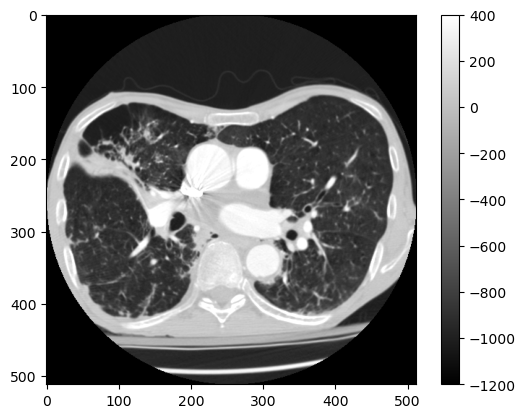

Displaying pre_processed-multimodalpulmonaryembolismdataset-6-7.npy


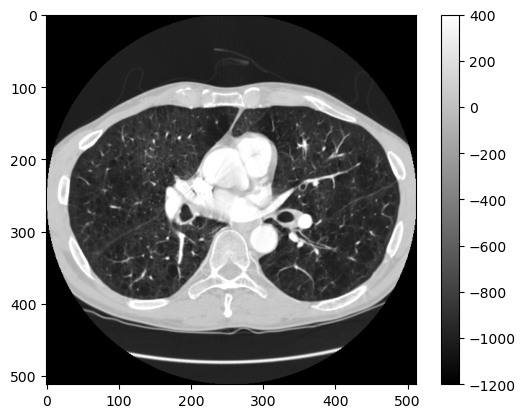

Displaying processed_0.npy


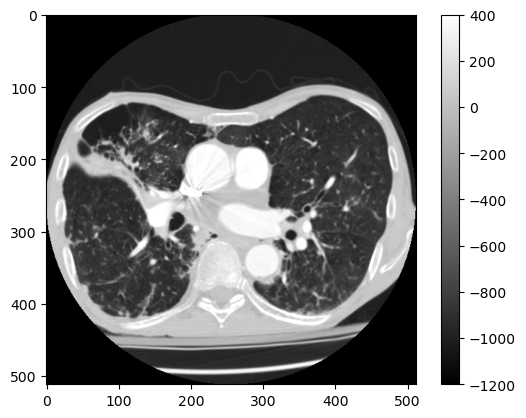

Displaying pre_processed-multimodalpulmonaryembolismdataset-0-1007.npy


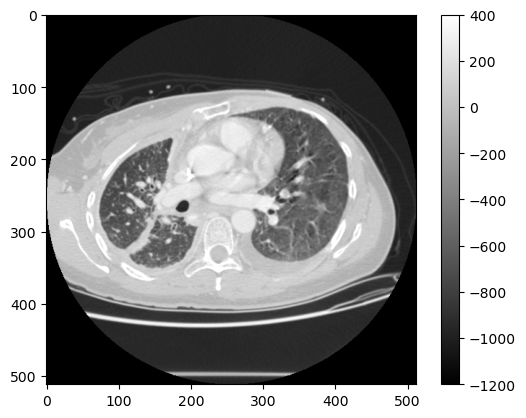

Displaying processed_2000.npy


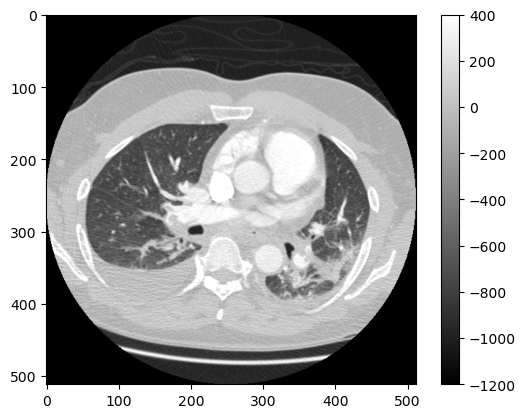

In [12]:
folder_path = "processed_npy/"
process_folder_for_visualization(folder_path)